# Linear inverse solutions in NumPy

An exploration of linear seismic inversion — considering the particular problem of getting reflectivity from a seismic trace, given the wavelet.

We'll be working on a model, so we know the correct answer from the start.

**This notebook requires Python 3.5, Numpy 1.11, and scikit-learn 0.18.**

In [1]:
import sys
sys.version

'3.5.2 | packaged by conda-forge | (default, Jul 26 2016, 01:32:08) \n[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]'

In [2]:
import numpy as np
np.__version__

'1.11.2'

In [3]:
import sklearn
sklearn.__version__

'0.18'

Now for the rest of the preliminaries.

In [4]:
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

## Some helpful functions

These are some functions we will use later. I'm defining them up-front so that we can talk about the maths without too much code getting in the way. It's probably best to ignore these for now, but when we get to them, you might want to come back here to understand what they do.

In [6]:
def norm(m):
    return m.T @ m

def misfit(d, d_pred):
    misfit = (d_pred - d).T @ (d_pred - d)
    return np.asscalar(misfit)

In [7]:
from scipy import linalg as spla

def convmtx(h, n):
    """
    Equivalent of MATLAB's convmtx function, http://www.mathworks.com/help/signal/ref/convmtx.html.
    
    Makes the convolution matrix, C. The product C.x is the convolution of h and x.
    
    Args
        h (ndarray): a 1D array, the kernel.
        n (int): the number of rows to make.
        
    Returns
        ndarray. Size m+n-1
    """
    col_1 = np.r_[h[0], np.zeros(n-1)]
    row_1 = np.r_[h, np.zeros(n-1)]
    return spla.toeplitz(col_1, row_1)

In [9]:
convmtx([1, -1], 5)

array([[ 1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -1.]])

## Construct the model m

We start with the slightly odd-seeming number of samples 51. This is because when we calculate the impedance contrasts (reflectivities), we'll lose a sample. Since I'd like 50 samples in the final reflectivity model `m`, we have to start with 50 + 1 samples in the impedance model.

In [10]:
# Impedance, imp     VP    RHO
imp = np.ones(51) * 2550 * 2650
imp[10:15] =        2700 * 2750
imp[15:27] =        2400 * 2450
imp[27:35] =        2800 * 3000

Make a consistent `x` space for the model to live in. This might be 'depth'.

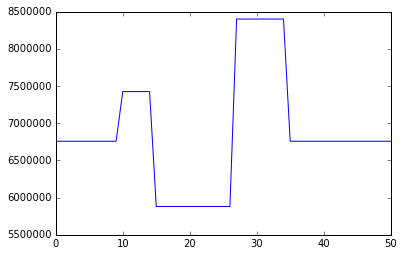

In [11]:
plt.plot(imp)
plt.show()

But I really want to use the reflectivity, so let's compute that:

In [12]:
m = (imp[1:] - imp[:-1]) / (imp[1:] + imp[:-1])

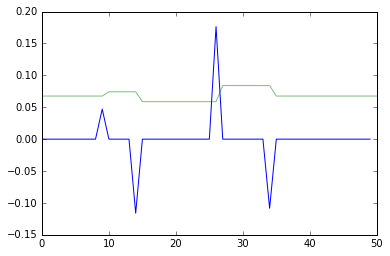

In [13]:
plt.plot(m)

# We can plot the impedance too, scaled to fit on this plot, so we
# can see how the interface property relates to the rock property.
plt.plot(imp/1e8, alpha=0.5)
plt.show()

Notice that we lost a sample: now there are only 50 samples. This is what we wanted.

## Forward operator: convolution with wavelet

Now we make the kernel matrix *G*, which represents convolution.

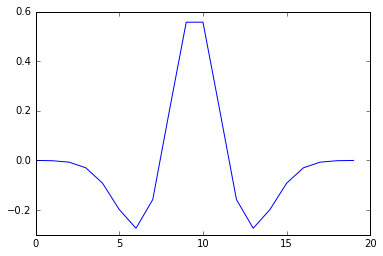

In [14]:
from scipy.signal import ricker
wavelet = ricker(points=20, a=2)

plt.plot(wavelet)
plt.show()

Let's normalize the wavelet amplitude to 1 so that the amplitude relates directly to the reflectivity.

In [16]:
wavelet /= np.amax(wavelet)

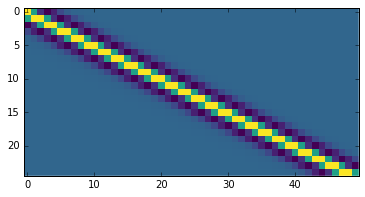

In [17]:
# Downsampling: set to 1 to use every sample.
s = 2

# Make G.
G = convmtx(wavelet, m.size)[::s, 10:60]
plt.imshow(G, cmap='viridis', interpolation='none')
plt.show()

In [ ]:
# Or we can use bruges (pip install bruges)
# from bruges.filters import ricker
# wavelet = ricker(duration=0.04, dt=0.001, f=100)
# G = convmtx(wavelet, m.size)[::s, 21:71]

# f, (ax0, ax1) = plt.subplots(1, 2)
# ax0.plot(wavelet)
# ax1.imshow(G, cmap='viridis', interpolation='none', aspect='auto')

## Forward model the data d

Now we can perform the forward problem: computing the data. We use the formulation

$$ \mathbf{d} = \mathbf{Gm} $$

Note that this equation is often rearranged and written $$ \mathbf{Ax} = \mathbf{b} $$ in linear algebra textbooks and in other tutorials, etc. Just in case you're looking for more examples. In that case, **A** is analogous to **G**, and **b** to **d**, and we're solving for **x** not **m**. All just notation &mdash; we can of course call things whatever we want.

In [20]:
d = G @ m

Let's visualize these components for fun. This is Figure 1 in the printed manuscript. I've hidden all the plotting in the `utils.py` file. You could do the basics with a lot less code, but I wanted it to look nice for the paper.

/home/matt/anaconda/envs/linalg/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


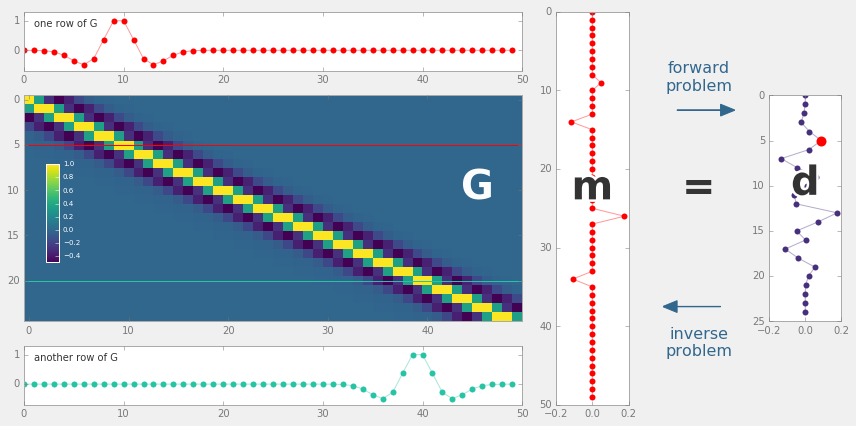

In [21]:
from utils import plot_gmd

plot_gmd(G, m, d)

Note that `G * m` gives us exactly the same result as `np.convolve(w_, m)`. This is just another way of implementing convolution that lets us use linear algebra to perform the operation, and its inverse.

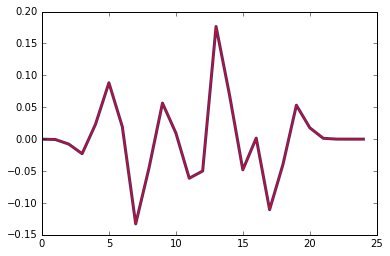

In [22]:
plt.plot(np.convolve(wavelet, m, mode='same')[::s], c='#462f7c', lw=3)
plt.plot(G @ m, 'red')

Now we can move on to the more interesting problem: if we only know a few measurements (i.e. this data `d`) and the kernel `G` that represents our understanding of the geophysics, can we _guess_ the model? 

<hr />

## Noise-free: minimum norm

In [23]:
# If G is square and invertible, we can use the inverse directly:
# m_est = la.inv(G) @ d

# If G is fat (more columns than rows: underdetermined system),
# then we use the 'right' pseduo-inverse of G:
m_est = G.T @ la.inv(G @ G.T) @ d

# If G is skinny (more rows than columns: overdetermined),
# we use the left inverse:
# m_est = la.inv(G.T @ G) @ G.T @ d

d_pred = G @ m_est

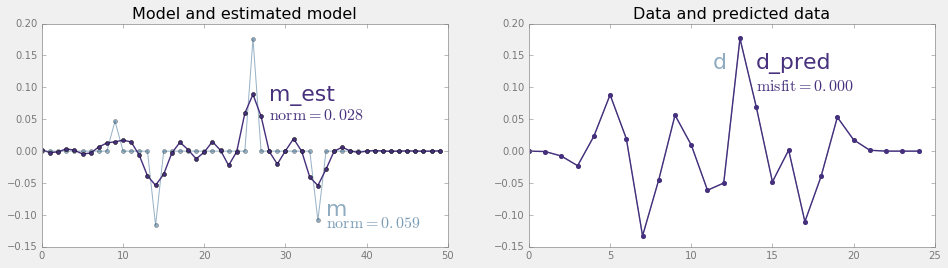

In [24]:
from utils import plot_two  # A print-ready plot

plot_two(m, d, m_est, d_pred)

It's interesting to look at these intermediate arrays:

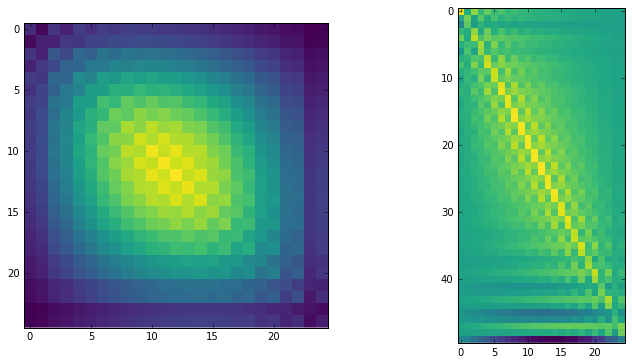

In [31]:
fig = plt.figure(figsize=(12,6))
ax0 = fig.add_subplot(121)
_ = ax0.imshow(la.inv(G @ G.T), cmap='viridis', interpolation='none')
ax1 = fig.add_subplot(122)
_ = ax1.imshow(G.T @ la.inv(G @ G.T), cmap='viridis', interpolation='none')

<hr />

## Aside: minimum norm without inverting G

["Don't invert that matrix!"](http://www.johndcook.com/blog/2010/01/19/dont-invert-that-matrix/) — says John Cook, and we should listen to John because he is much smarter than us.

OK, no problem... We can use other solvers, like `np.linalg.solve`, or `scipy.linalg.lu_solve`. These are implemented via LAPACK `gesv` and are much faster than inverting matrices with NumPy. 

### linalg.solve or linalg.lstsq

In [32]:
try:
    """Exact solution, matrix must be square and full-rank."""
    m_est = la.solve(G, d)
    print("Exact solution.")
except la.LinAlgError:
    """The problem is underdetermined, find optimal solution."""
    m_est = la.lstsq(G, d)[0]
    print("Best solution by least squares.")

d_pred = G @ m_est

Best solution by least squares.


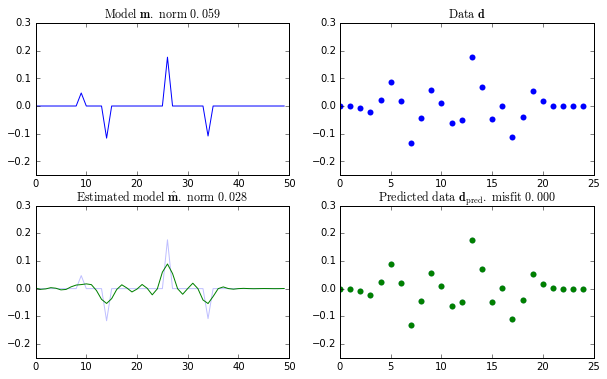

In [33]:
from utils import plot_all

plot_all(m, d, m_est, d_pred)

This is essentially exactly what we got before using our method with inversion.

### QR factorization

Only works if **G** is square.

In [35]:
q, r = la.qr(G)

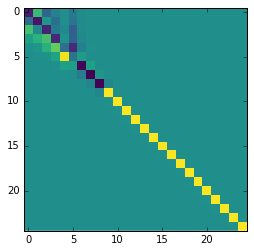

In [36]:
plt.imshow(q, cmap='viridis', interpolation='none')
plt.show()

In [ ]:
m_est = la.inv(r) @ q.T @ d
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred, equalize=False)

# NB This block will fail if G is not square.

### LU factorization

Again, **G** must be square.

In [ ]:
lu, piv = spla.lu_factor(G)
plt.imshow(lu, cmap='viridis', interpolation='none')
plt.show()

# NB This block will fail if G is not square.

In [ ]:
m_est = spla.lu_solve((lu, piv), d)
d_pred = G @ m_est
plot_all(m, d, m_est, d_pred, equalize=False)